In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.parser import parse
import datetime as dt
from datetime import datetime, timedelta
from sklearn import preprocessing
import os
from scipy.stats import kstest
from scipy.stats import mannwhitneyu
from scipy import stats

На АЗС 051 28.02 были изменены цены на бензины - снижены до уровня Роснефти.  
H0 - средние значения анализируемых выборок совпадают (эффекта нет от изменения цен нет, стат.значимых различий не обнаружено)  
H1 - измененеие цен привело к увеличению продаж по бензинам (обнаружены статистически значимые различия между средними значениями выборок после изменения цен) 

Для анализа рассмотрены выборки двух АЗС со схожей среднесуточной реализацией по бензинам до изменения цен.
Анализируемая метрика: объём продаж бензинов   

# Загрузка данных  

In [80]:
list_product = [
    'Бензин АИ-92',
    'Бензин АИ-95'
]

In [81]:
df_01 = pd.read_csv(r"D:\QS\2024\oil\operational\preprocessed_operational\2024_01", parse_dates=['FL_EVBDATE']) \
    .query('PROD_NAME == @list_product & type_client == "ФЛ" & FL_EVBDATE > "2024-01-09"')

In [82]:
df_02 = pd.read_csv(r"D:\QS\2024\oil\operational\preprocessed_operational\2024_02", parse_dates=['FL_EVBDATE']) \
    .query('PROD_NAME == @list_product & type_client == "ФЛ"')

In [83]:
df_03 = pd.read_csv(r"D:\QS\current_month\preprocessed_operational", parse_dates=['FL_EVBDATE']) \
    .query('PROD_NAME == @list_product & type_client == "ФЛ"')

In [84]:
df = pd.concat([df_01, df_02, df_03], ignore_index=True)

# Подбор ствнций, которая схожа по среднесуточной реализации бензинов до изменения цен с АЗС 051  

In [85]:
df.head(2)

,AZS_NUM,AZS_NAME,FL_EVBDATE,FL_EVBTIME,TIME_KEY,PAY_NAME,FL_VOLUME,FL_MASSA,MASSA_TN,PROD_NAME,KS_WRKPLACE,KS_DOCNUM,KS_EV_NAME,FL_TANK,FL_TRK,FL_HAND,type_client
0,696.0,АЗС 696,2024-01-29,17:01:12,2024-01-29,Яндекс (Физ. лица),28.68,21.8283,0.021828,Бензин АИ-95,20,0,Продажа,1,3,2,ФЛ
1,2.0,АЗС 002,2024-01-29,20:33:34,2024-01-29,Яндекс (Физ. лица),41.00,31.0493,0.031049,Бензин АИ-95,20,0,Продажа,2,3,1,ФЛ


ССР по бензинам АЗС 051 до изменения цен

In [88]:
df \
    .query('FL_EVBDATE < "2024-02-28" & AZS_NAME == "АЗС 051"') \
    .groupby('FL_EVBDATE', as_index=False) \
    .agg({'MASSA_TN': 'sum'}).MASSA_TN.mean()

11.626826924489794

In [89]:
df \
    .query('FL_EVBDATE < "2024-02-28"') \
    .groupby(['AZS_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'MASSA_TN': 'sum'}) \
    .groupby('AZS_NAME', as_index=False) \
    .agg({'MASSA_TN': 'mean'}) \
    .query('MASSA_TN > 11 & MASSA_TN < 12')

,AZS_NAME,MASSA_TN
25,АЗС 051,11.626827
56,АЗС 099,11.023770
79,АЗС 158,11.095773
89,АЗС 173,11.234326
100,АЗС 206,11.889421
111,АЗС 268,11.517571
122,АЗС 298,11.278471


для анализа возьму 3 выборки:  
1. АЗС 051  
2. АЗС 206  
3. АЗС 268  

In [135]:
list_azs = [
    'АЗС 051',
    'АЗС 173',
    'АЗС 268'
]

In [136]:
# продажи до изменения цена на АЗС 051
df_1 = df \
    .query('FL_EVBDATE < "2024-02-28" & AZS_NAME == @list_azs') \
    .groupby(['FL_EVBDATE', 'AZS_NAME'], as_index=False) \
    .agg({'MASSA_TN': 'sum'})

### Проверка схожести выборок по среднесуточной реализации до изменения цен при помощи критерия Колмагорова-Смирнова

H0 - распределения одинаковы  
H1 - распределения различны

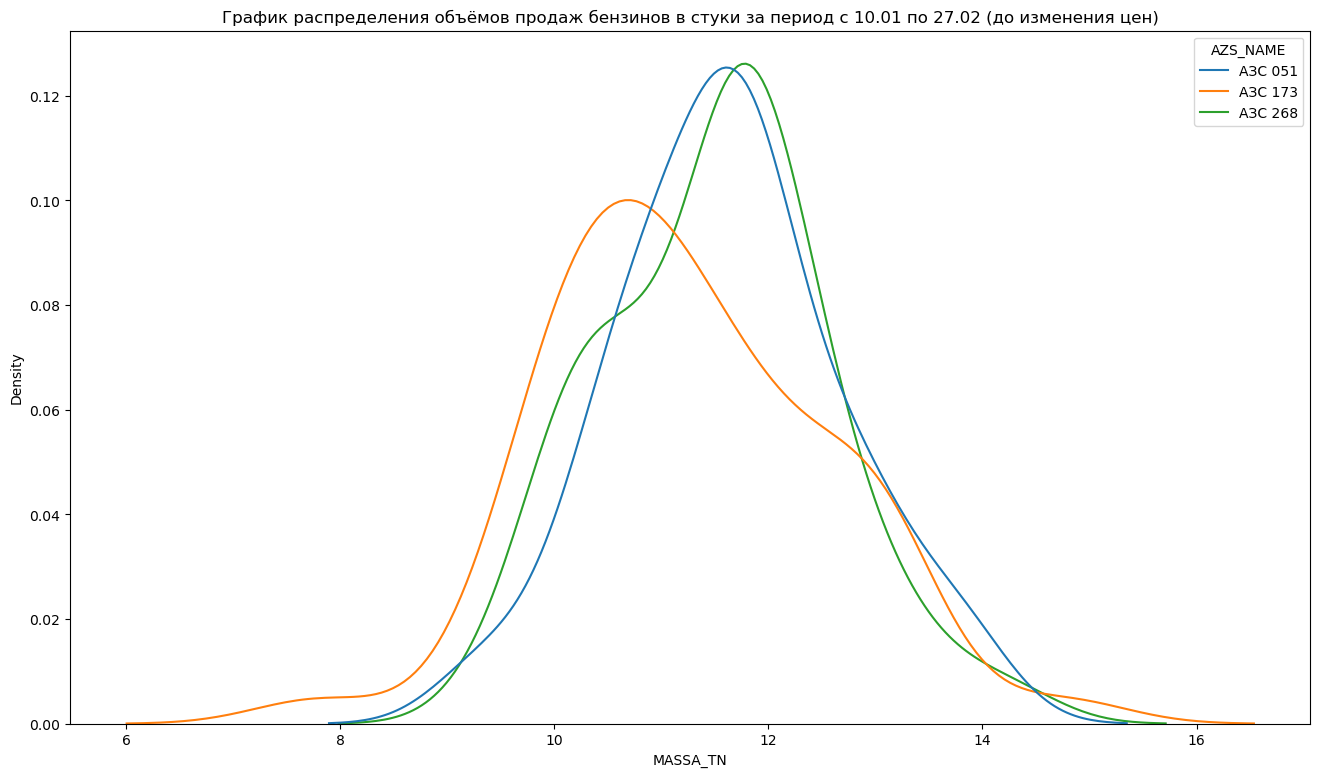

In [145]:
plt.figure(figsize=(16,9))
sns.kdeplot(data=df_1, x='MASSA_TN', hue='AZS_NAME')
plt.title('График распределения объёмов продаж бензинов в стуки за период с 10.01 по 27.02 (до изменения цен)')
plt.show();

In [146]:
# проверка схожести выборок АЗС 051 и 268
stat, p_value = kstest(df_1.query('AZS_NAME == "АЗС 051"')['MASSA_TN'],
                      df_1.query('AZS_NAME == "АЗС 268"')['MASSA_TN'])
if p_value < 0.05:
    print('Выборки различаются')
else:
    print('Выборки схожи')

Выборки схожи


In [147]:
# проверка схожести выборок АЗС 051 и 173
stat, p_value = kstest(df_1.query('AZS_NAME == "АЗС 051"')['MASSA_TN'],
                      df_1.query('AZS_NAME == "АЗС 173"')['MASSA_TN'])
if p_value < 0.05:
    print('Выборки различаются')
else:
    print('Выборки схожи')

Выборки схожи


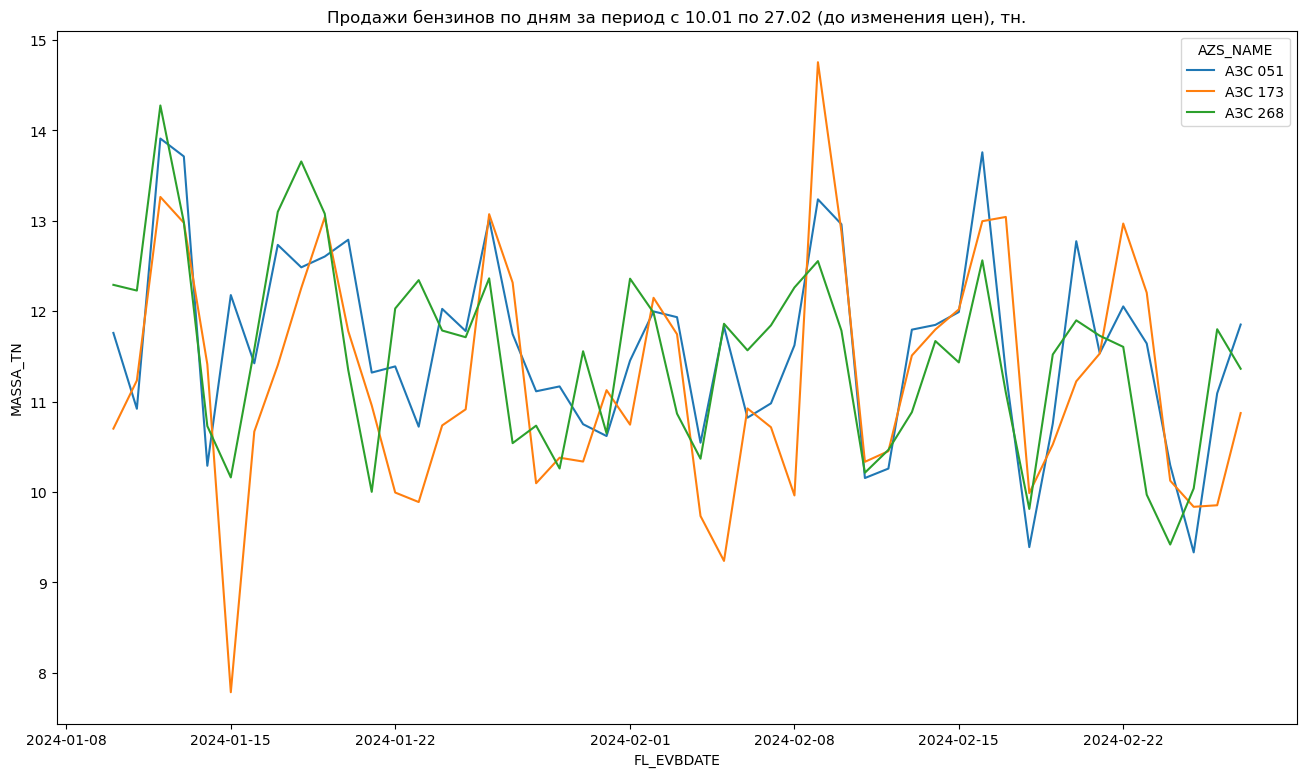

In [149]:
plt.figure(figsize=(16,9))
sns.lineplot(data=df_1, 
             x='FL_EVBDATE', y='MASSA_TN', hue='AZS_NAME')
plt.title('Продажи бензинов по дням за период с 10.01 по 27.02 (до изменения цен), тн.')
plt.show();

Проверка распределний на нормальность

In [150]:
# АЗС 051
if stats.shapiro(df_1.query('AZS_NAME == "АЗС 051"')['MASSA_TN']).pvalue >= 0.05:
    print('Распределение нормальное')
else:
    print('Распределение не нормальное\n')

Распределение нормальное


In [151]:
# АЗС 268
if stats.shapiro(df_1.query('AZS_NAME == "АЗС 268"')['MASSA_TN']).pvalue >= 0.05:
    print('Распределение нормальное')
else:
    print('Распределение не нормальное\n')

Распределение нормальное


In [152]:
# АЗС 173
if stats.shapiro(df_1.query('AZS_NAME == "АЗС 173"')['MASSA_TN']).pvalue >= 0.05:
    print('Распределение нормальное')
else:
    print('Распределение не нормальное\n')

Распределение нормальное


In [153]:
df_1.query('AZS_NAME == "АЗС 051"').shape[0]

49

1. Размер выборок небольшой - по 49 наблюдений  
2. В выборках данные распределены нормально
3. Выборки независимые  

Для проверки гипотез можно использовать статистические криетрии:    
- U-Манна-Уитни  

# Сравнение выборок до изменения цен   
H0 - нет статистических различий  
H1 - между выборками есть стат.различия

## АЗС 051 и АЗС 268

In [154]:
# АЗС 51 и АЗС 268
if stats.mannwhitneyu(df_1.query('AZS_NAME == "АЗС 051"')['MASSA_TN'], 
                   df_1.query('AZS_NAME == "АЗС 268"')['MASSA_TN']).pvalue >= 0.05:
    print("Средние двух выборок схожи")
else:
    print("Средние двух выборок различны")
    
pv = stats.mannwhitneyu(df_1.query('AZS_NAME == "АЗС 051"')['MASSA_TN'], 
                   df_1.query('AZS_NAME == "АЗС 268"')['MASSA_TN']).pvalue
print(f'p-value = {pv}')

Средние двух выборок схожи
p-value = 0.6391097435458941


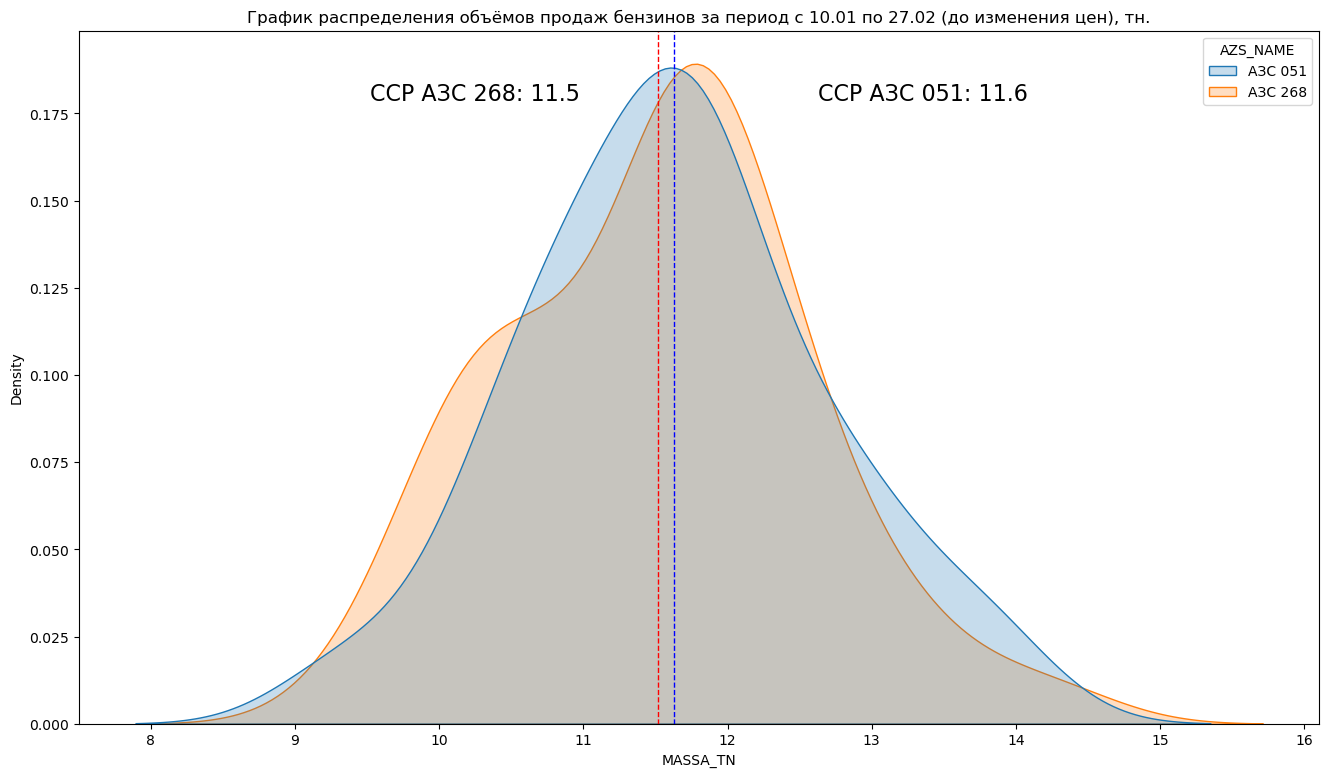

In [159]:
plt.figure(figsize=(16,9))
t = df_1.query('AZS_NAME == "АЗС 268" | AZS_NAME == "АЗС 051"')
sns.kdeplot(data=t, x='MASSA_TN', hue='AZS_NAME', fill=True)

min_ylim, max_ylim = plt.ylim()

sa = t[t.AZS_NAME == 'АЗС 051'].MASSA_TN.mean()
sb = t[t.AZS_NAME == 'АЗС 268'].MASSA_TN.mean()


plt.axvline(sa, color='b', linestyle='dashed', linewidth=1)
plt.text(sa+1, max_ylim*0.9,
         f'ССР АЗС 051: {round(sa,1)}', fontdict={'fontsize': 16})

plt.axvline(sb, color='r', linestyle='dashed', linewidth=1)
plt.text(sb-2, max_ylim*0.9,
         f'ССР АЗС 268: {round(sb,1)}', fontdict={'fontsize': 16})
plt.title('График распределения объёмов продаж бензинов за период с 10.01 по 27.02 (до изменения цен), тн.')
plt.show();

За период с 10 января по 27 февраля 2024 года среднесуточная реализация бензинов на АЗС 051 и 268 практически схожи. АЗС 051 - 11,6 тн., АЗС 268 - 11,5 тн.

## АЗС 051 и АЗС 173

In [156]:
# АЗС 51 и АЗС 206
if stats.mannwhitneyu(df_1.query('AZS_NAME == "АЗС 051"')['MASSA_TN'], 
                   df_1.query('AZS_NAME == "АЗС 173"')['MASSA_TN']).pvalue >= 0.05:
    print("Средние двух выборок схожи")
else:
    print("Средние двух выборок различны")
    
pv = stats.mannwhitneyu(df_1.query('AZS_NAME == "АЗС 051"')['MASSA_TN'], 
                   df_1.query('AZS_NAME == "АЗС 173"')['MASSA_TN']).pvalue
print(f'p-value = {pv}')

Средние двух выборок схожи
p-value = 0.07111796782343811


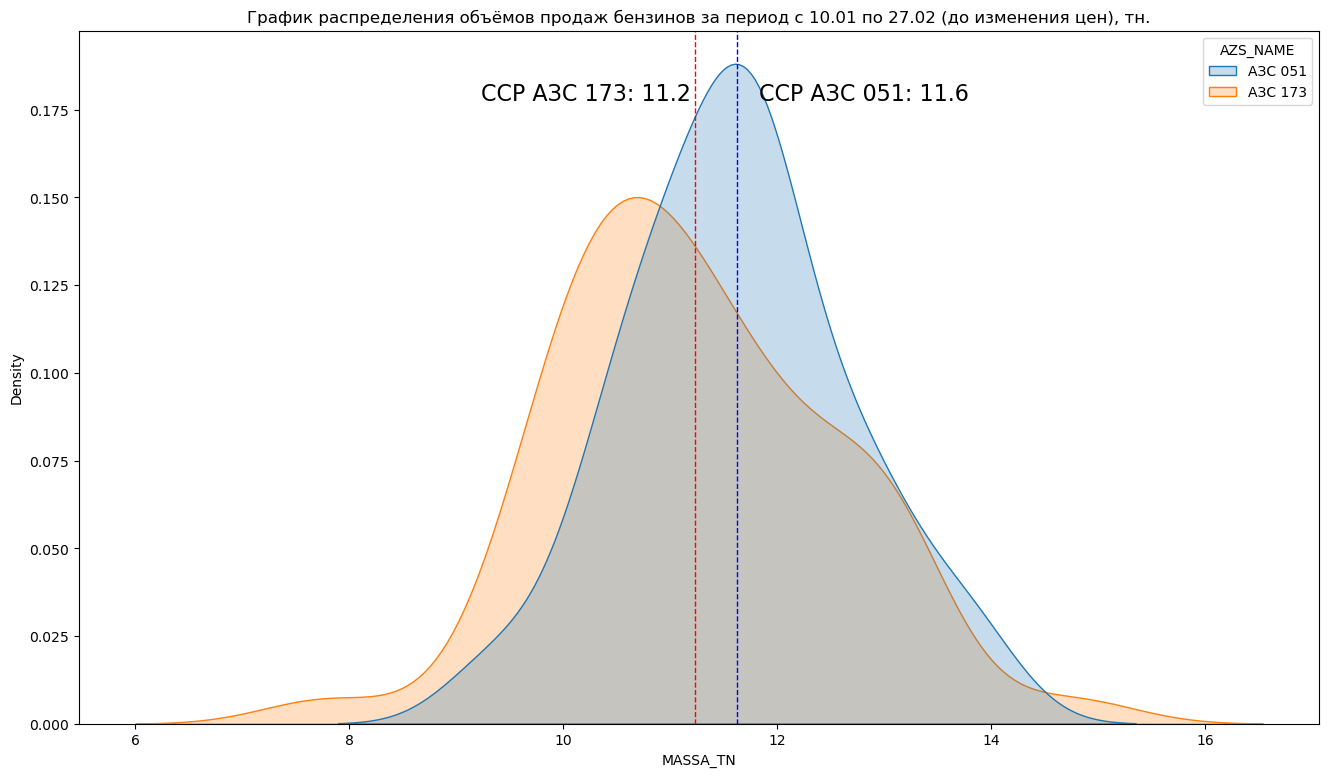

In [167]:
plt.figure(figsize=(16,9))
t = df_1.query('AZS_NAME == "АЗС 173" | AZS_NAME == "АЗС 051"')
sns.kdeplot(data=t, x='MASSA_TN', hue='AZS_NAME', fill=True)

min_ylim, max_ylim = plt.ylim()

sa = t[t.AZS_NAME == 'АЗС 051'].MASSA_TN.mean()
sb = t[t.AZS_NAME == 'АЗС 173'].MASSA_TN.mean()


plt.axvline(sa, color='b', linestyle='dashed', linewidth=1)
plt.text(sa+0.2, max_ylim*0.9,
         f'ССР АЗС 051: {round(sa,1)}', fontdict={'fontsize': 16})

plt.axvline(sb, color='r', linestyle='dashed', linewidth=1)
plt.text(sb-2, max_ylim*0.9,
         f'ССР АЗС 173: {round(sb,1)}', fontdict={'fontsize': 16})
plt.title('График распределения объёмов продаж бензинов за период с 10.01 по 27.02 (до изменения цен), тн.')
plt.show();

*Вывод:*  
Средние значения продаж в адрес ФЛ анализируемых выборок до изменения цн: 
- АЗС 051 и АЗС 268 схожи;  
- АЗС 051 и АЗС 206 схожи.

# Анализ после изменения цен  
## АЗС 051 и АЗС 268  

In [192]:
list_azs = [
    'АЗС 051',
    'АЗС 268'
]

In [193]:
df_2 = df \
    .query('FL_EVBDATE >= "2024-02-28" & AZS_NAME == @list_azs') \
    .groupby(['FL_EVBDATE', 'AZS_NAME'], as_index=False) \
    .agg({'MASSA_TN': 'sum'})

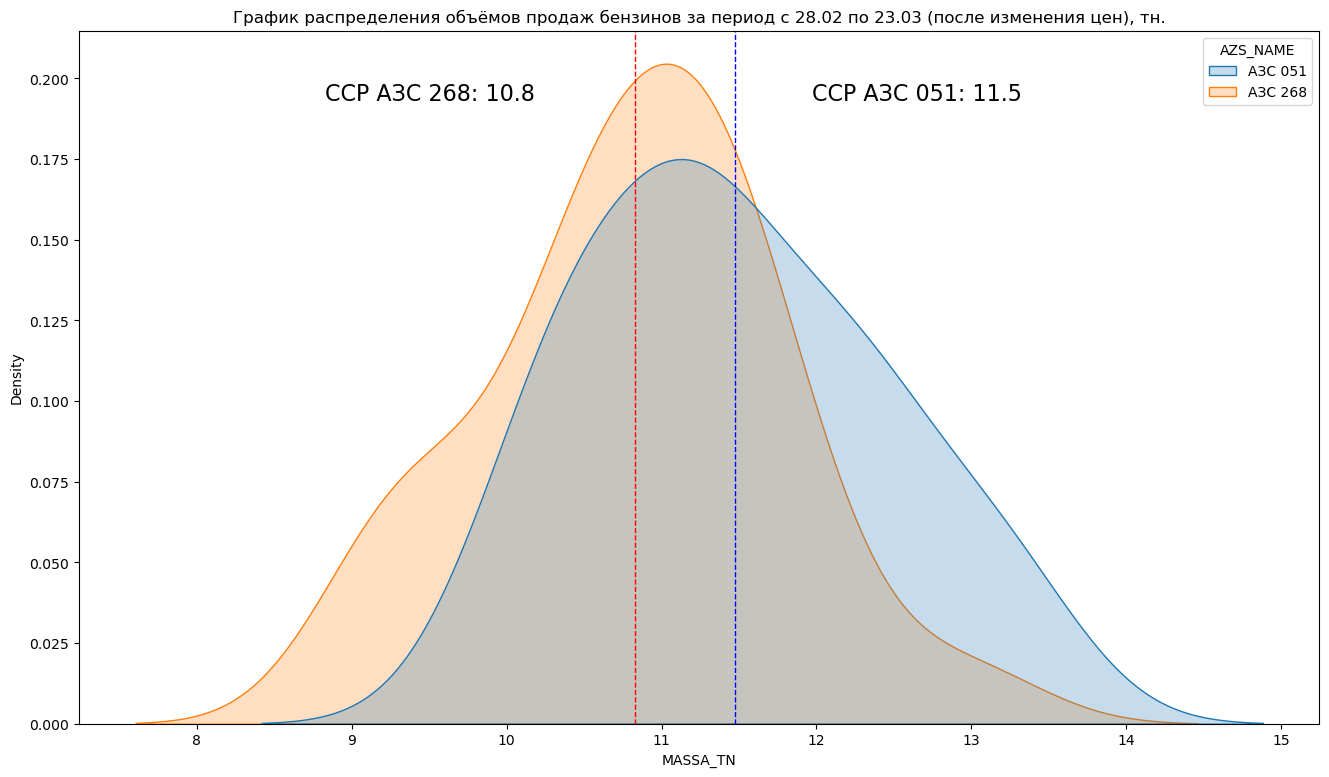

In [194]:
plt.figure(figsize=(16,9))
sns.kdeplot(data=df_2, x='MASSA_TN', hue='AZS_NAME', fill=True)

min_ylim, max_ylim = plt.ylim()

sa = df_2[df_2.AZS_NAME == 'АЗС 051'].MASSA_TN.mean()
sb = df_2[df_2.AZS_NAME == 'АЗС 268'].MASSA_TN.mean()


plt.axvline(sa, color='b', linestyle='dashed', linewidth=1)
plt.text(sa+0.5, max_ylim*0.9,
         f'ССР АЗС 051: {round(sa,1)}', fontdict={'fontsize': 16})

plt.axvline(sb, color='r', linestyle='dashed', linewidth=1)
plt.text(sb-2, max_ylim*0.9,
         f'ССР АЗС 268: {round(sb,1)}', fontdict={'fontsize': 16})
plt.title('График распределения объёмов продаж бензинов за период с 28.02 по 23.03 (после изменения цен), тн.')
plt.show();

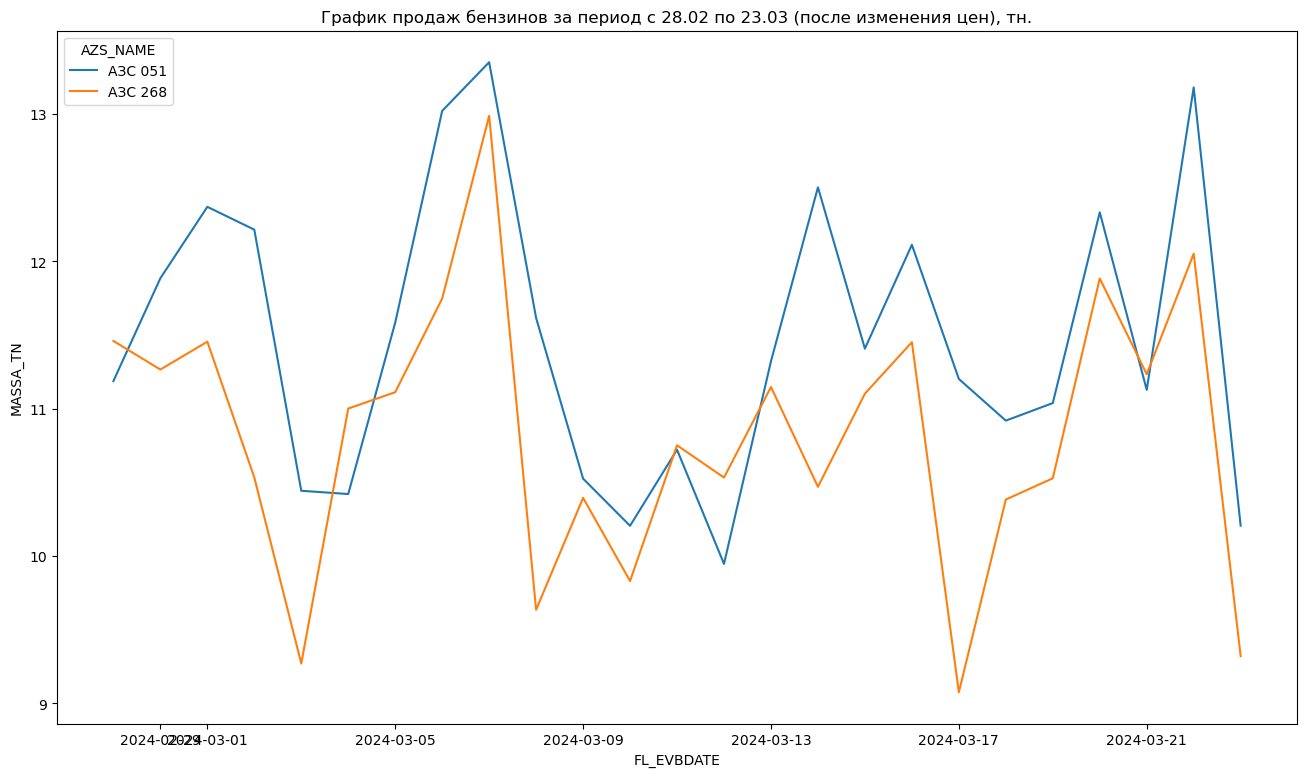

In [195]:
plt.figure(figsize=(16,9))
sns.lineplot(data=df_2, 
             x='FL_EVBDATE', y='MASSA_TN', hue='AZS_NAME')
plt.title('График продаж бензинов за период с 28.02 по 23.03 (после изменения цен), тн.')
plt.show();

In [196]:
# АЗС 051
if stats.shapiro(df_2.query('AZS_NAME == "АЗС 051"')['MASSA_TN']).pvalue >= 0.05:
    print('Распределение нормальное')
else:
    print('Распределение не нормальное\n')

Распределение нормальное


In [197]:
# размер выборки
df_2.query('AZS_NAME == "АЗС 051"').shape[0]

25

In [198]:
# АЗС 268
if stats.shapiro(df_2.query('AZS_NAME == "АЗС 268"')['MASSA_TN']).pvalue >= 0.05:
    print('Распределение нормальное')
else:
    print('Распределение не нормальное\n')

Распределение нормальное


In [199]:
# размер выборки
df_2.query('AZS_NAME == "АЗС 268"').shape[0]

25

In [200]:
stats.shapiro(df_2.query('AZS_NAME == "АЗС 268"')['MASSA_TN'])

ShapiroResult(statistic=0.9713757634162903, pvalue=0.6801105737686157)

In [201]:
if stats.mannwhitneyu(df_2.query('AZS_NAME == "АЗС 051"')['MASSA_TN'],
                      df_2.query('AZS_NAME == "АЗС 268"')['MASSA_TN']).pvalue >= 0.05:
    print("Средние двух выборок схожи")
else:
    print("Средние двух выборок различны")
    
pv = stats.mannwhitneyu(df_2.query('AZS_NAME == "АЗС 051"')['MASSA_TN'],
                        df_2.query('AZS_NAME == "АЗС 268"')['MASSA_TN']).pvalue
print(f'p-value = {pv}')

Средние двух выборок различны
p-value = 0.045663178484859054


In [202]:
11.693197-10.987875

0.7053219999999989

*Вывод:*   
Обнаружены статистически значимые различия в объёмах продаж в среднем в стуки между выборками (АЗС 051 и АЗС 268) после изменения цен на АЗС 051 на бензины.  
На АЗС 051 после изменения цен среднесуточная реализация снизилась на 0.1 тн.:  
- до изменения цен 11.6 тн.  
- после изменения цен 11.5 тн.  

На АЗС 268 произошло более значительное падение ССР:  
- до изменения цен 11,5 тн.
- после изменения цен 10,8 тн.  

Значение p-value на грани. Нельзя сделать вывод о том, что на АЗС 051 изменение цен повлияло.

# АЗС 051 и АЗС 173 после изменения цен

In [204]:
list_azs = [
    'АЗС 051',
    'АЗС 173'
]

In [205]:
df_2 = df \
    .query('FL_EVBDATE >= "2024-02-28" & AZS_NAME == @list_azs') \
    .groupby(['FL_EVBDATE', 'AZS_NAME'], as_index=False) \
    .agg({'MASSA_TN': 'sum'})

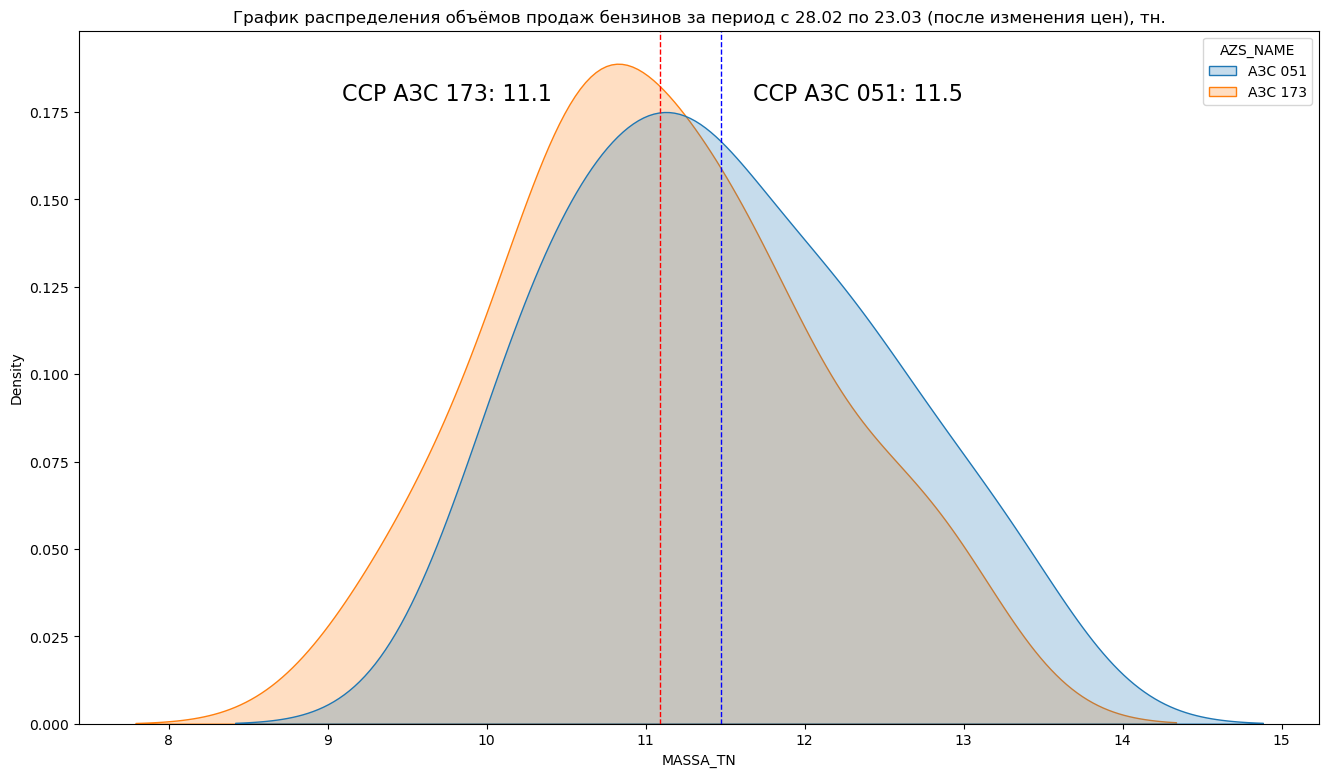

In [206]:
plt.figure(figsize=(16,9))
sns.kdeplot(data=df_2, x='MASSA_TN', hue='AZS_NAME', fill=True)

min_ylim, max_ylim = plt.ylim()

sa = df_2[df_2.AZS_NAME == 'АЗС 051'].MASSA_TN.mean()
sb = df_2[df_2.AZS_NAME == 'АЗС 173'].MASSA_TN.mean()


plt.axvline(sa, color='b', linestyle='dashed', linewidth=1)
plt.text(sa+0.2, max_ylim*0.9,
         f'ССР АЗС 051: {round(sa,1)}', fontdict={'fontsize': 16})

plt.axvline(sb, color='r', linestyle='dashed', linewidth=1)
plt.text(sb-2, max_ylim*0.9,
         f'ССР АЗС 173: {round(sb,1)}', fontdict={'fontsize': 16})
plt.title('График распределения объёмов продаж бензинов за период с 28.02 по 23.03 (после изменения цен), тн.')
plt.show();

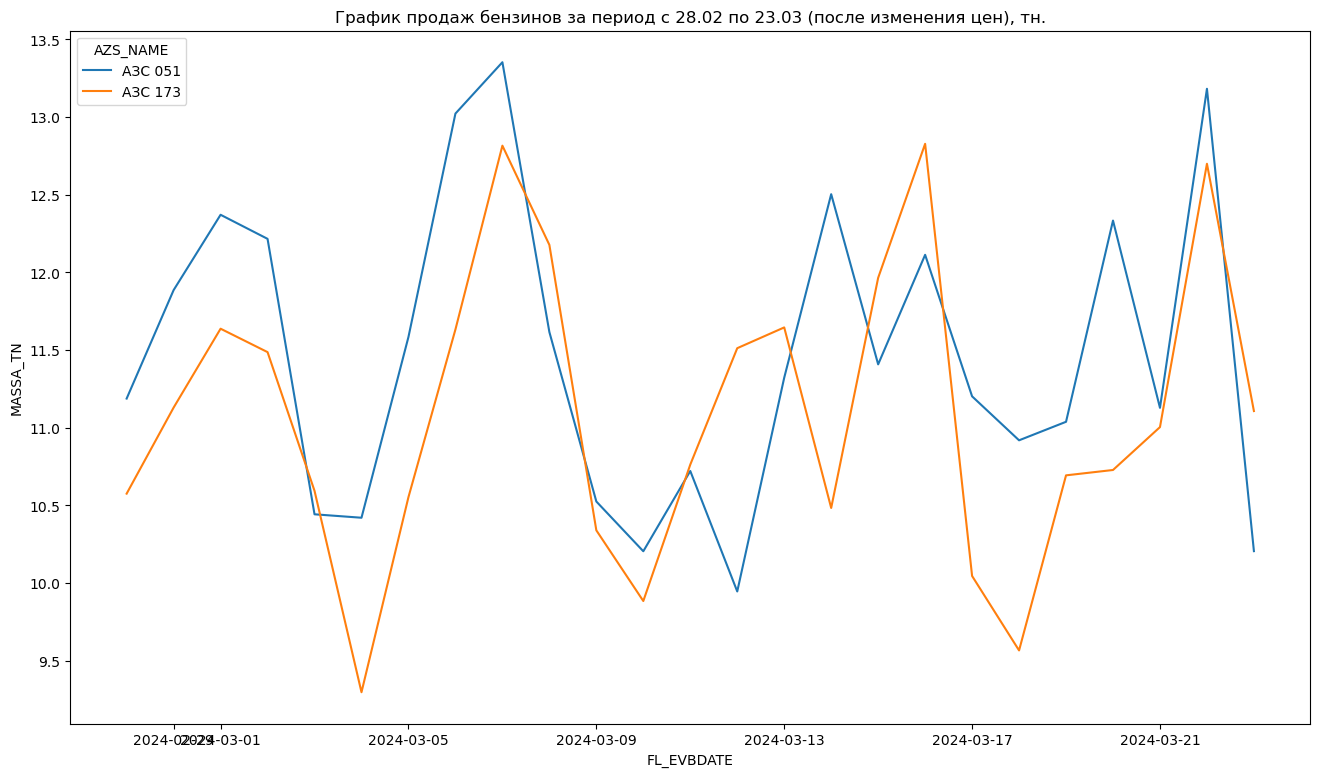

In [207]:
plt.figure(figsize=(16,9))
sns.lineplot(data=df_2, 
             x='FL_EVBDATE', y='MASSA_TN', hue='AZS_NAME')
plt.title('График продаж бензинов за период с 28.02 по 23.03 (после изменения цен), тн.')
plt.show();

In [209]:
if stats.mannwhitneyu(df_2.query('AZS_NAME == "АЗС 051"')['MASSA_TN'],
                      df_2.query('AZS_NAME == "АЗС 173"')['MASSA_TN']).pvalue >= 0.05:
    print("Средние двух выборок схожи")
else:
    print("Средние двух выборок различны")
    
pv = stats.mannwhitneyu(df_2.query('AZS_NAME == "АЗС 051"')['MASSA_TN'],
                        df_2.query('AZS_NAME == "АЗС 173"')['MASSA_TN']).pvalue
print(f'p-value = {pv}')

Средние двух выборок схожи
p-value = 0.23658179688216296


*Вывод:*   
Статистически значимых различий в объёмах продаж в среднем в стуки между выборками АЗС 051 и АЗС 206 после изменения цен на АЗС 051 на бензины не обнаружено.  
Снижение цен на бензины на АЗС 051 не привело к увеличению продаж.  